In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer

In [3]:
data = pd.read_csv('/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Codes/kMC ordenado/data.csv')
data = data.drop(['Unnamed: 10'], axis=1)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data['Fuente(experimento)'] = data.index.astype(str) + '_' + data['Fuente'] + ' (' + data['Experimento'] + ')'
data = data.drop(['Fuente','Experimento'], axis=1)
data.insert(0, 'T0', 0)
data

,T0,T1,T2,T3,T4,T5,T6,T7,T8,Fuente(experimento)
0,0,7.356582,12.689700,16.639759,18.501776,20.487569,23.818749,27.994834,30.050587,0_Adsorcion de As+5 Espana ( 60ppmSb-As)
1,0,20.779935,25.251636,27.748749,29.965348,32.368957,36.389638,43.149442,48.682691,1_Adsorcion de As+5 Espana ( 60ppmAs-As)
2,0,17.067494,22.581181,27.208246,29.441427,31.863017,35.913776,42.724149,48.187964,2_Adsorcion de As+5 Espana ( 90ppmAs-As)
3,0,1.145313,1.696100,2.264219,3.106472,3.699600,4.016499,4.056284,4.106165,3_Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb)
4,0,6.008902,10.187933,12.134026,13.930267,15.141939,16.922354,20.326410,23.376360,4_Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb)
5,0,27.241766,41.585839,46.084479,48.311079,49.992389,52.567519,55.551390,57.868871,5_Adsorcion de Sb Espana ( 60ppmSb-Sb)
6,0,34.587323,41.906065,44.300046,46.055632,46.967624,48.723210,51.983584,54.331965,6_Adsorcion de Sb Espana ( 60ppmAs-Sb)
7,0,29.154068,36.910247,42.092633,43.724502,44.948404,50.227982,62.491001,64.050876,7_Adsorcion de Sb Espana ( 60ppmHg-Sb)
8,0,21.817095,29.432051,34.577737,37.286592,39.562941,43.523788,51.331664,56.111996,8_Adsorcion de Sb Espana ( 120ppmAs-Sb)
9,0,12.184766,16.710792,20.125645,22.100067,23.401391,26.923940,33.789545,37.715952,9_Adsorcion de Sb Espana ( 120ppmSb-Sb)


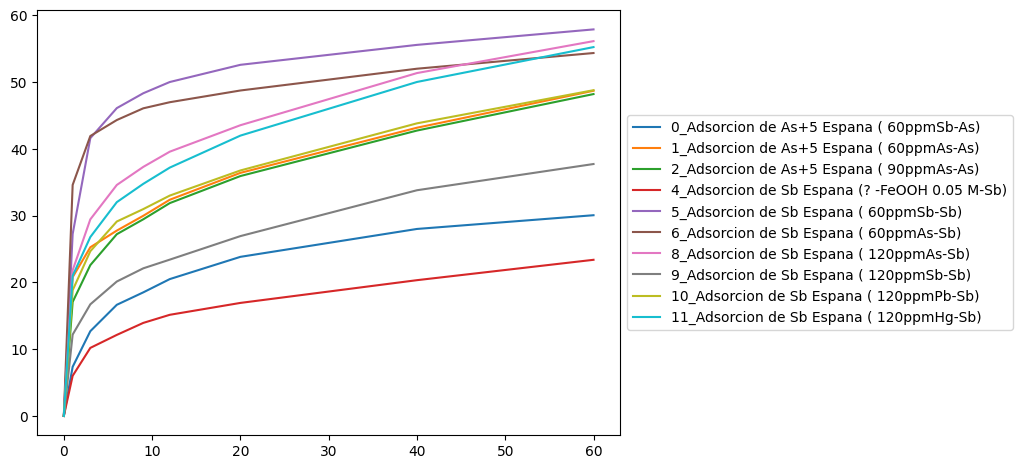

In [4]:
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

for i in range(len(data)):
    if i != 3 and i != 7:
        valores_numericos = pd.to_numeric(data.iloc[i], errors='coerce').dropna()
        etiqueta = data.iloc[i]['Fuente(experimento)']
        plt.plot(time_array, valores_numericos.values, label=etiqueta)

plt.legend()
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        

In [5]:
import numpy as np
import matplotlib.pyplot as plt # Necesario para el ejemplo de graficación

class KineticMonteCarlo:
    def __init__(self, lattice_size, T, processes, time_array, time_factor=1e-7):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.processes = processes
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        
        self.time_array = time_array
        self.time = self.time_array[0]
        
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {p: 0 for p in self.processes.keys()}
        
        # Para el historial de conteo de eventos
        self.event_times_history = [] 
        self.events_history_data = {p: [] for p in self.processes.keys()}

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def calculate_transition_rates(self, site):
        rates = {}
        n_ij = self.count_occupied_neighbors(site)

        if "adsorption" in self.processes:
            if self.lattice[site] == 0:
                e_ads = self.processes["adsorption"]["e_ads"]
                e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
                E_ads = e_int_abs * n_ij + e_ads
                k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
                rates["adsorption"] = k_ads
            else:
                rates["adsorption"] = 0.0

        if "desorption" in self.processes:
            if self.lattice[site] == 1:
                e_des = self.processes["desorption"]["e_des"]
                e_int_des = self.processes["desorption"].get("e_int_des", 0)
                E_des = e_int_des * n_ij + e_des
                k_des = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
                rates["desorption"] = k_des
            else:
                rates["desorption"] = 0.0

        if "diffusion" in self.processes:
            if self.lattice[site] == 1:
                e_diff = self.processes["diffusion"]["e_diff"]
                E_diff = e_diff 
                k_diff = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_diff / (self.k_b * self.T))
                rates["diffusion"] = k_diff
            else:
                rates["diffusion"] = 0.0
        return rates

    def select_event(self, rates):
        total_propensity = sum(rates.values())
        if total_propensity == 0:
            return None
        r = np.random.rand() * total_propensity
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None

    def _record_event_history(self):
        """Registra el estado actual del conteo de eventos y el tiempo."""
        self.event_times_history.append(self.time)
        for process_name in self.processes.keys():
            self.events_history_data[process_name].append(self.events_count[process_name])

    def run_simulation(self):
        end_time = self.time_array[-1]
        last_recorded_occupancy_index = -1
        

        self._record_event_history()

        while self.time < end_time:
            for i in range(last_recorded_occupancy_index + 1, len(self.time_array)):
                t_record = self.time_array[i]
                if self.time >= t_record:
                    if self.occupancy[t_record] is None:
                        self.occupancy[t_record] = np.sum(self.lattice == 1) / (self.lattice_size**2) * 100
                    last_recorded_occupancy_index = i
                else:
                    break

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            if not rates or sum(rates.values()) == 0:

                if np.sum(self.lattice) == self.lattice_size**2 and "desorption" not in rates : # Si está lleno y no hay desorción
                     # print("Lattice lleno y sin desorción, terminando simulación.")
                     break
                if np.sum(self.lattice) == 0 and "adsorption" not in rates: # Si está vacío y no hay adsorción
                    # print("Lattice vacío y sin adsorción, terminando simulación.")
                    break
                continue


            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            
            # Guardar el tiempo *antes* de actualizarlo, si el evento ocurre
            time_before_event = self.time
            self.time += delta_t

            event_type = self.select_event(rates)

            event_occurred = False
            if event_type == "adsorption":
                self.lattice[site] = 1
                self.events_count[event_type] += 1
                event_occurred = True
            elif event_type == "desorption":
                self.lattice[site] = 0
                self.events_count[event_type] += 1
                event_occurred = True
            elif event_type == "diffusion":
                neighbors_coords = [
                    (site[0] + dx, site[1] + dy)
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                    if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                ]
                vacant_neighbors = [s_neighbor for s_neighbor in neighbors_coords if self.lattice[s_neighbor] == 0]
                if vacant_neighbors:
                    new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                    self.lattice[site], self.lattice[new_site] = 0, 1
                    self.events_count[event_type] += 1
                    event_occurred = True
            
            if event_occurred:
                self._record_event_history()


        final_occupancy_val = np.sum(self.lattice == 1) / (self.lattice_size**2) * 100
        for t_record_idx in range(len(self.time_array)):
            t_val = self.time_array[t_record_idx]
            if self.occupancy[t_val] is None:
                if self.time >= t_val : # Si la simulación pasó o alcanzó este punto de tiempo
                    self.occupancy[t_val] = final_occupancy_val


        return self.occupancy

    def reset_lattice(self):
        self.lattice = np.zeros((self.lattice_size, self.lattice_size))
        self.time = self.time_array[0]
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {p: 0 for p in self.processes.keys()}
        
        self.event_times_history = []
        self.events_history_data = {p: [] for p in self.processes.keys()}

In [6]:
class KMCModelOptimizer:
    def __init__(self, exp_data, param_ranges, n_calls=200):
        self.exp_data = exp_data
        self.param_ranges = param_ranges
        self.n_calls = n_calls
        self.best_params = None
        self.best_error = float("inf")
        self.progress_bar = tqdm(total=self.n_calls, desc="Optimización Bayesiana en Progreso", position=0, ncols=100)

    def loss_function(self, params):
        # Desempaquetar parámetros de acuerdo a lo que se pasa
        param_dict = {}
        param_names = list(self.param_ranges.keys())

        for i, param_name in enumerate(param_names):
            param_dict[param_name] = params[i]

        # Construir el diccionario de procesos
        processes = {}
        if 'e_ads' in param_dict:
            processes["adsorption"] = {"e_ads": param_dict["e_ads"], "e_int_abs": param_dict.get("e_int_abs", 0.1)}
        if 'e_des' in param_dict:
            processes["desorption"] = {"e_des": param_dict["e_des"], "e_int_des": param_dict.get("e_int_des", 0.7)}
        if 'e_diff' in param_dict:
            processes["diffusion"] = {"e_diff": param_dict["e_diff"]}

        # Ejecutar el modelo KMC
        kmc_model = KineticMonteCarlo(
            lattice_size=int(param_dict['lattice_size']), T=param_dict['T'],
            processes=processes,
            time_array=np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
        )

        kmc_model.reset_lattice()
        kmc_model.run_simulation()

        # Calcular error
        simulated_data = np.array(list(kmc_model.occupancy.values()))
        error = np.mean((simulated_data - self.exp_data) ** 2)

        # Actualizar mejores parámetros si se encuentra un menor error
        if error < self.best_error:
            self.best_error = error
            self.best_params = param_dict

        # Actualizar la barra de progreso con información relevante
        self.progress_bar.set_postfix({
            "Mejor error": f"{self.best_error:.6f}",
            "Parámetros óptimos": f"{self.best_params}",
            "Progreso": f"{self.progress_bar.n}/{self.progress_bar.total}"
        })
        self.progress_bar.update(1)

        return error

    def optimize(self):
        # Definir el espacio de búsqueda dinámicamente solo con los parámetros presentes
        space = []
        param_names = list(self.param_ranges.keys())

        for param_name in param_names:
            if param_name == 'e_ads' and 'e_ads' in self.param_ranges:
                space.append(Real(self.param_ranges['e_ads'][0], self.param_ranges['e_ads'][1], name="e_ads"))
            elif param_name == 'e_des' and 'e_des' in self.param_ranges:
                space.append(Real(self.param_ranges['e_des'][0], self.param_ranges['e_des'][1], name="e_des"))
            elif param_name == 'e_diff' and 'e_diff' in self.param_ranges:
                space.append(Real(self.param_ranges['e_diff'][0], self.param_ranges['e_diff'][1], name="e_diff"))
            elif param_name == 'e_int_abs' and 'e_int_abs' in self.param_ranges:
                space.append(Real(self.param_ranges['e_int_abs'][0], self.param_ranges['e_int_abs'][1], name="e_int_abs"))
            elif param_name == 'e_int_des' and 'e_int_des' in self.param_ranges:
                space.append(Real(self.param_ranges['e_int_des'][0], self.param_ranges['e_int_des'][1], name="e_int_des"))
            elif param_name == 'lattice_size' and 'lattice_size' in self.param_ranges:
                space.append(Integer(self.param_ranges['lattice_size'][0], self.param_ranges['lattice_size'][1], name="lattice_size"))
            elif param_name == 'T' and 'T' in self.param_ranges:
                space.append(Real(self.param_ranges['T'][0], self.param_ranges['T'][1], name="T"))

        # Iniciar optimización
        start_time = time.time()
        result = gp_minimize(self.loss_function, space, n_calls=self.n_calls, random_state=42)
        self.progress_bar.close()

        # Mostrar resultados finales
        end_time = time.time()
        print("\n✅ Optimización completada")
        print("🔹 Parámetros óptimos encontrados:", self.best_params)
        print("🔹 Error mínimo encontrado:", self.best_error)
        print(f"⏳ Tiempo total de ejecución: {end_time - start_time:.2f} segundos")
        
        # Pasar los mejores parámetros al modelo KMC
        self.run_kmc_with_best_params()

    def run_kmc_with_best_params(self):
        if self.best_params:
            # Construir el diccionario de procesos con los mejores parámetros
            processes = {}
            if 'e_ads' in self.best_params:
                processes["adsorption"] = {"e_ads": self.best_params["e_ads"], "e_int_abs": self.best_params.get("e_int_abs", 0.1)}
            if 'e_des' in self.best_params:
                processes["desorption"] = {"e_des": self.best_params["e_des"], "e_int_des": self.best_params.get("e_int_des", 0.7)}
            if 'e_diff' in self.best_params:
                processes["diffusion"] = {"e_diff": self.best_params["e_diff"]}

            # Crear el modelo KMC con los mejores parámetros encontrados
            kmc_model = KineticMonteCarlo(
                lattice_size=int(self.best_params['lattice_size']), T=self.best_params['T'],
                processes=processes,
                time_array=np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
            )

            # Ejecutar la simulación con los mejores parámetros
            kmc_model.run_simulation()
            print(f"Modelo KMC ejecutado con los mejores parámetros: {self.best_params}")
        else:
            print("No se encontraron parámetros óptimos para ejecutar el modelo KMC.")


{'adsorption': 21539, 'desorption': 6493, 'diffusion': 15}


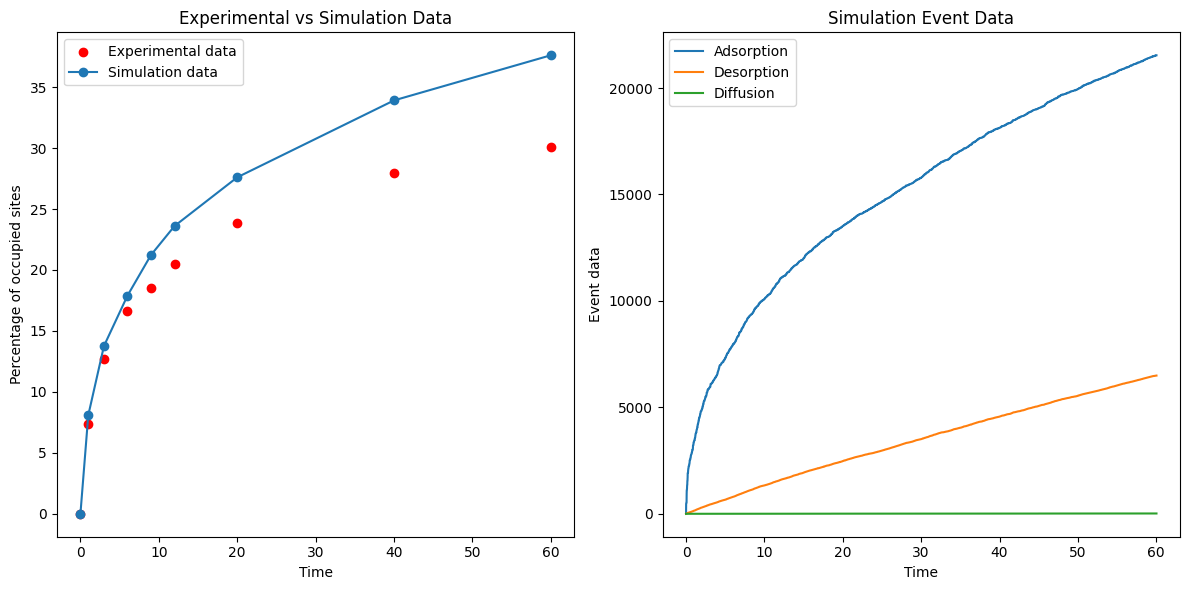

Mean Squared Error (MSE): 14.107885219007382


In [7]:
processes = {
    "adsorption": {"e_ads": 0.07, "e_int_abs": -0.008},
    "desorption": {"e_des": 0.257, "e_int_des": 0.007},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 200
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[0, 9]
simulated_data = result.values()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1 (Top left)
axs[0].scatter(time_array, data.iloc[0, :9].to_numpy(), color='red', label='Experimental data')
axs[0].plot(time_array, simulated_data, marker='o', label='Simulation data')
axs[0].legend()
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Percentage of occupied sites")
axs[0].set_title("Experimental vs Simulation Data")

# Plot 2 (Right side - Adsorption, Desorption, Diffusion)
axs[1].plot(sim.event_times_history, sim.events_history_data['adsorption'], label='Adsorption')
axs[1].plot(sim.event_times_history, sim.events_history_data['desorption'], label='Desorption')
axs[1].plot(sim.event_times_history, sim.events_history_data['diffusion'], label='Diffusion')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Event data")
axs[1].set_title("Simulation Event Data")
axs[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

mse = np.mean((data.iloc[0, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")



In [68]:
exp_data = data.iloc[0, :9].to_numpy()  # Datos experimentales para la optimización

param_ranges = {
    "e_ads": (0.1, 0.5),
    "e_des": (0.1, 0.5),
    "e_diff": (0.01, 0.5),
    "e_int_abs": (-0.1, 0.1),
    "e_int_des": (-0.1, 0.1),
    "lattice_size": (250, 1000),
    "T": (298, 305)
}


optimizer = KMCModelOptimizer(exp_data, param_ranges, n_calls=100)
optimizer.optimize()


Optimización Bayesiana en Progreso:   0%| | 0/100 [00:00<?, ?it/s, Mejor error=389.513770, Parámetro

Optimización Bayesiana en Progreso:  26%|▎| 26/100 [19:28<55:25, 44.93s/it, Mejor error=5.931824, Pa
Optimización Bayesiana en Progreso:  60%|▌| 60/100 [23:37<15:44, 23.62s/it, Mejor error=6.345422, Pa
Optimización Bayesiana en Progreso: 100%|█| 100/100 [07:11<00:00,  4.31s/it, Mejor error=1.429814, P



✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.10925323936092565, 'e_des': 0.5, 'e_diff': 0.09909798257365486, 'e_int_abs': 0.06803507019315697, 'e_int_des': -0.028047350630366216, 'lattice_size': np.int64(250), 'T': 301.6759375352173}
🔹 Error mínimo encontrado: 1.429814154109973
⏳ Tiempo total de ejecución: 431.49 segundos
Modelo KMC ejecutado con los mejores parámetros: {'e_ads': 0.10925323936092565, 'e_des': 0.5, 'e_diff': 0.09909798257365486, 'e_int_abs': 0.06803507019315697, 'e_int_des': -0.028047350630366216, 'lattice_size': np.int64(250), 'T': 301.6759375352173}


{'adsorption': 100421, 'desorption': 47, 'diffusion': 15}


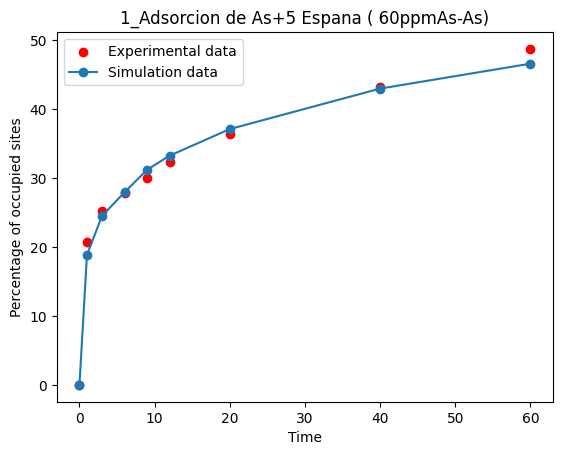

Mean Squared Error (MSE): 1.2980917006901143


In [ ]:
processes = {
    "adsorption": {"e_ads": 0.013, "e_int_abs": 0.072},
    "desorption": {"e_des": 0.32, "e_int_des": 0.02},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 400
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[1, 9]
simulated_data = result.values()
plt.scatter(time_array, data.iloc[1, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title(title)
plt.show()

mse = np.mean((data.iloc[1, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

{'adsorption': 99536, 'desorption': 280, 'diffusion': 23}


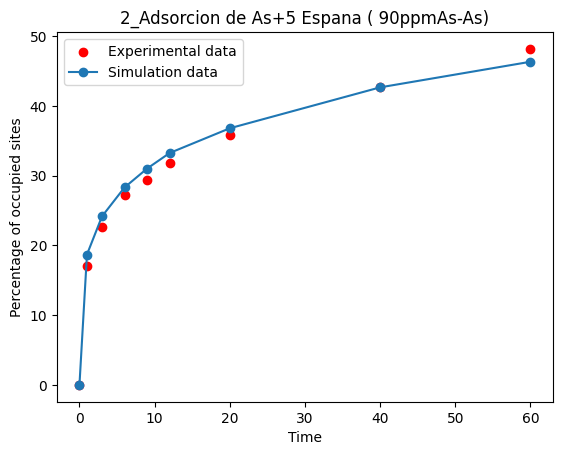

Mean Squared Error (MSE): 1.6781212353915187


In [79]:
processes = {
    "adsorption": {"e_ads": 0.017, "e_int_abs": 0.0714},
    "desorption": {"e_des": 0.2, "e_int_des": 0.05},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 400
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[2, 9]
simulated_data = result.values()
plt.scatter(time_array, data.iloc[2, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title(title)
plt.show()

mse = np.mean((data.iloc[2, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

{'adsorption': 12594, 'desorption': 1073, 'diffusion': 8}


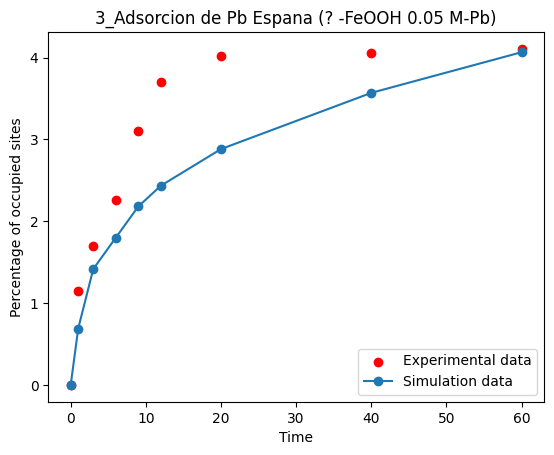

Mean Squared Error (MSE): 0.4982042950351141


In [76]:
processes = {
    "adsorption": {"e_ads": 0.02, "e_int_abs": 0.72},
    "desorption": {"e_des": 0.2, "e_int_des": 0.090},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 550
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[3, 9]
simulated_data = result.values()
plt.scatter(time_array, data.iloc[3, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title(title)
plt.show()

mse = np.mean((data.iloc[3, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

{'adsorption': 134043, 'desorption': 2678, 'diffusion': 10}


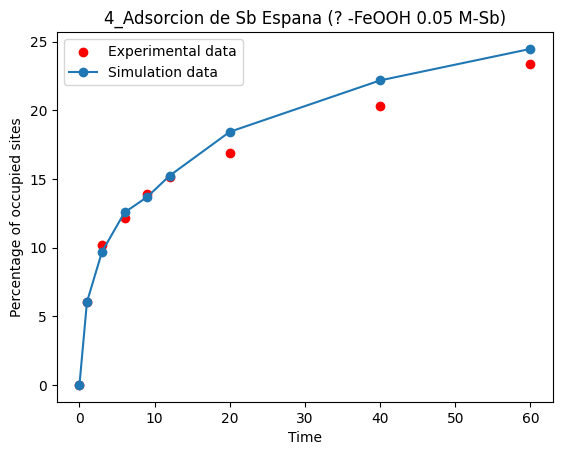

Mean Squared Error (MSE): 0.8239207930406329


In [81]:
processes = {
    "adsorption": {"e_ads": 0.09, "e_int_abs": 0.063},
    "desorption": {"e_des": 0.2, "e_int_des": 0.05},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 690
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[4, 9]
simulated_data = result.values()
plt.scatter(time_array, data.iloc[4, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title(title)
plt.show()

mse = np.mean((data.iloc[4, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

{'adsorption': 40609, 'desorption': 1430, 'diffusion': 10}


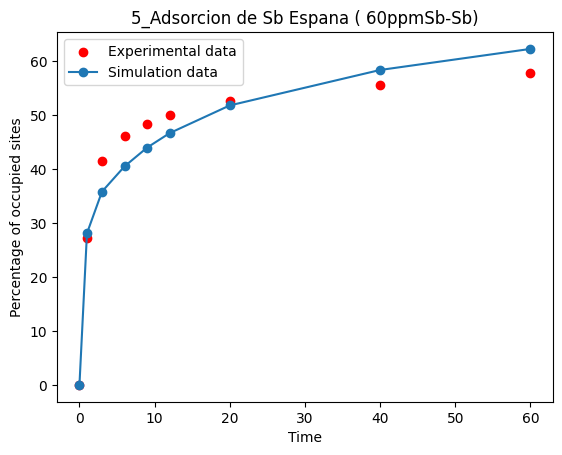

Mean Squared Error (MSE): 13.631650758380625


In [82]:
processes = {
    "adsorption": {"e_ads": 0.0009, "e_int_abs": 0.077},
    "desorption": {"e_des": 0.3, "e_int_des": 0.0009},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 200
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[5, 9]
simulated_data = result.values()
plt.scatter(time_array, data.iloc[5, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title(title)
plt.show()

mse = np.mean((data.iloc[5, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

{'adsorption': 39346, 'desorption': 1616, 'diffusion': 17}


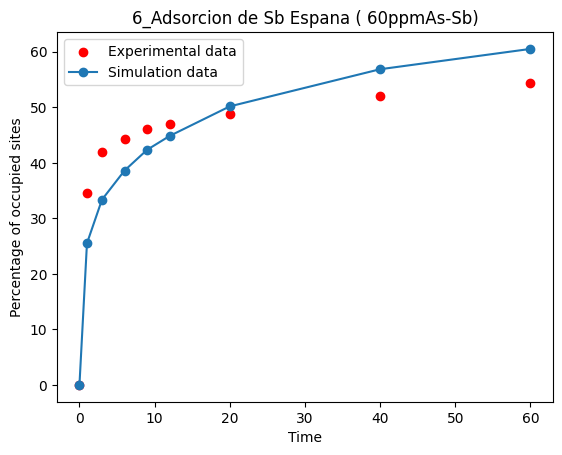

Mean Squared Error (MSE): 30.004757529370895


In [83]:
processes = {
    "adsorption": {"e_ads": 0.0009, "e_int_abs": 0.079},
    "desorption": {"e_des": 0.3, "e_int_des": 0.0006},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 200
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[6, 9]
simulated_data = result.values()
plt.scatter(time_array, data.iloc[6, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title(title)
plt.show()

mse = np.mean((data.iloc[6, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

{'adsorption': 60364, 'desorption': 153, 'diffusion': 12}


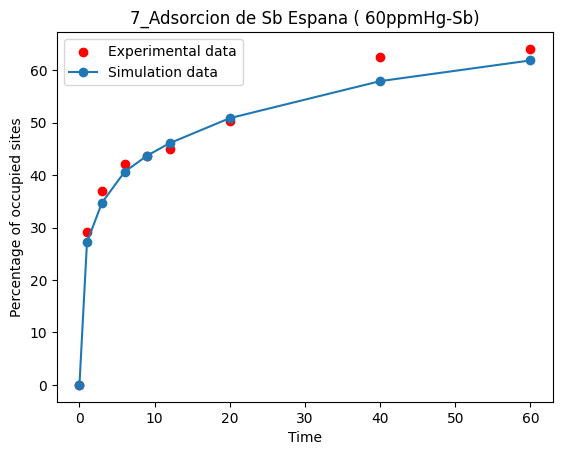

Mean Squared Error (MSE): 4.253059979237234


In [84]:
processes = {
    "adsorption": {"e_ads": 0.005, "e_int_abs": 0.07},
    "desorption": {"e_des": 0.2, "e_int_des": 0.05},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 250
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[7, 9]
simulated_data = result.values()
plt.scatter(time_array, data.iloc[7, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title(title)
plt.show()

mse = np.mean((data.iloc[7, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

{'adsorption': 137086, 'desorption': 254, 'diffusion': 14}


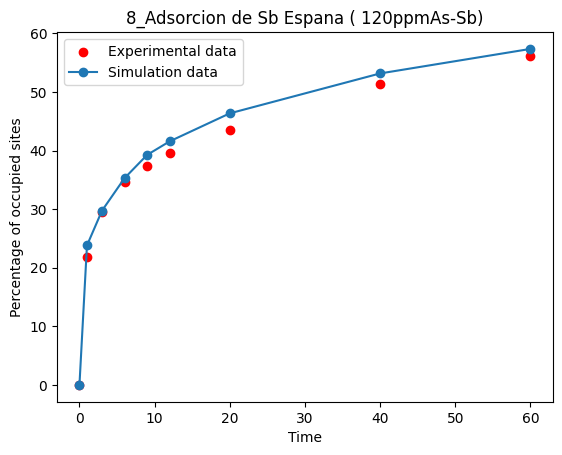

Mean Squared Error (MSE): 2.821546312434739


In [85]:
processes = {
    "adsorption": {"e_ads": 0.01, "e_int_abs": 0.065},
    "desorption": {"e_des": 0.2, "e_int_des": 0.05},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 400
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[8, 9]
simulated_data = result.values()
plt.scatter(time_array, data.iloc[8, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title(title)
plt.show()

mse = np.mean((data.iloc[8, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

{'adsorption': 75248, 'desorption': 1062, 'diffusion': 18}


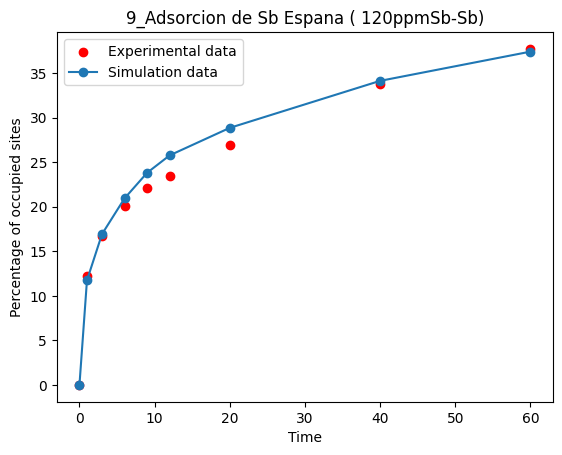

Mean Squared Error (MSE): 1.4851109853141182


In [86]:
processes = {
    "adsorption": {"e_ads": 0.081, "e_int_abs": 0.06},
    "desorption": {"e_des": 0.2, "e_int_des": 0.05},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 400
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[9, 9]
simulated_data = result.values()
plt.scatter(time_array, data.iloc[9, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title(title)
plt.show()

mse = np.mean((data.iloc[9, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

{'adsorption': 104270, 'desorption': 251, 'diffusion': 13}


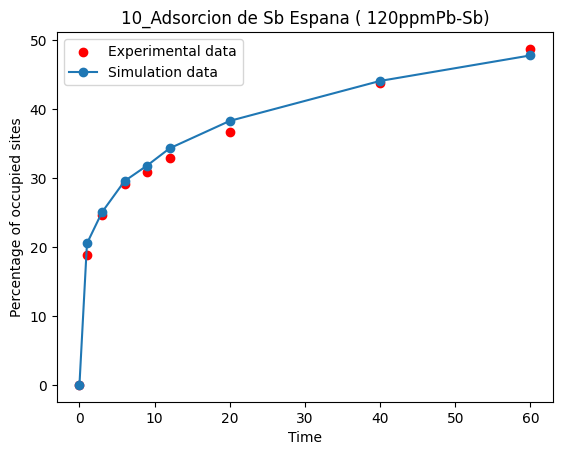

Mean Squared Error (MSE): 1.0381903389991916


In [87]:
processes = {
    "adsorption": {"e_ads": 0.009, "e_int_abs": 0.072},
    "desorption": {"e_des": 0.2, "e_int_des": 0.05},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 400
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[10, 9]
simulated_data = result.values()
plt.scatter(time_array, data.iloc[10, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title(title)
plt.show()

mse = np.mean((data.iloc[10, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

{'adsorption': 113322, 'desorption': 241, 'diffusion': 13}


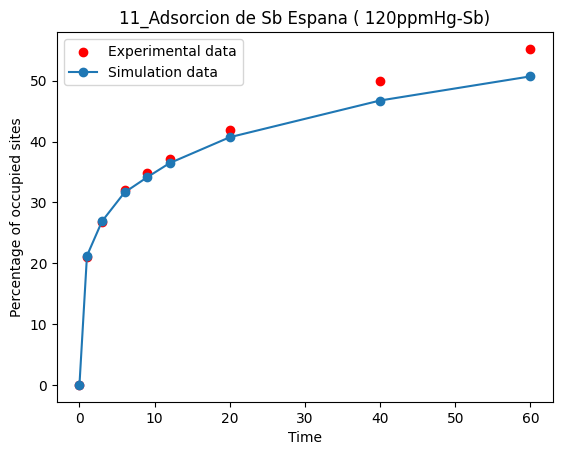

Mean Squared Error (MSE): 3.7453495819386777


In [88]:
processes = {
    "adsorption": {"e_ads": 0.009, "e_int_abs": 0.07},
    "desorption": {"e_des": 0.2, "e_int_des": 0.05},
    "diffusion": {"e_diff": 0.42}
}
lattice_size = 400
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)
title = data.iloc[11, 9]
simulated_data = result.values()
plt.scatter(time_array, data.iloc[11, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title(title)
plt.show()

mse = np.mean((data.iloc[11, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")